# Getting Started : Optimal Transport Between Two Datasets

This tutorial covers the most basic use of the `ott` toolbox:

- Compute the optimal transport between two point clouds using the {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` algorithm. 
- Use the seamless integration with `jax` to differentiate through this operation.

## Imports and toy data definition

`ott` is built on top of `jax`, so we use `jax` to define all the variables of the problem.

In [1]:
import jax
import jax.numpy as jnp

We also import `matplotlib` to plot the results.

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cycler

mpl.rcParams["axes.prop_cycle"] = cycler(
    color=[
        "#377eb8",
        "#ff7f00",
        "#4daf4a",
        "#f781bf",
        "#a65628",
        "#984ea3",
        "#999999",
        "#e41a1c",
        "#dede00",
    ]
)  # colorblind friendly cycle from https://gist.github.com/thriveth/8560036

We define a toy function and use it to generate two datasets of points, `x` and `y`:

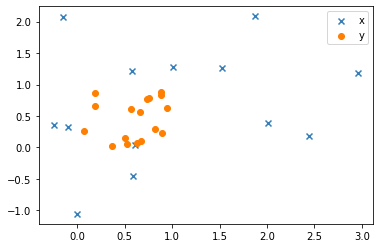

In [3]:
def create_points(rng, n_samples_x, n_samples_y, n_features):
    rngs = jax.random.split(rng, 3)
    x = jax.random.normal(rngs[0], (n_samples_x, n_features)) + 1
    y = jax.random.uniform(rngs[1], (n_samples_y, n_features))
    return x, y


rng = jax.random.PRNGKey(0)
n_samples_x, n_samples_y, n_features = 13, 17, 2
x, y = create_points(rng, n_samples_x, n_samples_y, n_features)

plt.scatter(x[:, 0], x[:, 1], label="x", marker="x")
plt.scatter(y[:, 0], y[:, 1], label="y")
plt.legend()

## Optimal transport with OTT

We will now use `ott` to compute the optimal transport between `x` and `y`. To do so, we first create a `geometry` object that defines the geometry between the two point clouds:

In [4]:
from ott.geometry import pointcloud

geometry = pointcloud.PointCloud(x, y)

`geometry` contains the two datasets `x` and `y`, as well as a `cost_fn` that is a way to measure distances between points. Here, we use the default settings, so the `cost_fn` is {class}`~ott.geometry.costs.SqEuclidean`, the standard squared Euclidean distance.

In order to compute the optimal transport corresponding to this `geometry`, we use the Sinkhorn algorithm. The Sinkhorn algorithm has an hyperparameter `epsilon` that controls the amount of regularization. It is stored in `geometry`, and by default it is 1/20th of the mean cost value.

In [5]:
from ott.solvers.linear import sinkhorn

ot = sinkhorn.solve(geometry)

As a small note: the computations here are *jitted*, meaning that the second time the solver is run it will be much faster:

In [6]:
ot = sinkhorn.solve(geometry)

This object `ot` contains all the information about the solution of the optimal transport problems, including the transport plan matrix that indicates how much of the mass of the point `x[i]` is moved towards `y[j]`.

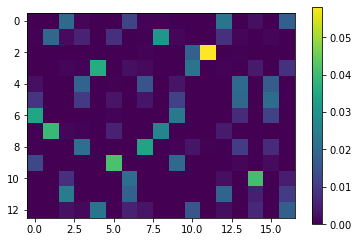

In [7]:
plt.imshow(ot.matrix)
plt.colorbar()

## Seamless integration in JAX automatic differentiation pipelines

We finish this quick tour by illustrating one of the most interesting feature of `ott`: it can be plugged easily into differentiable pipelines built in `jax`, like neural networks.

We demonstrate this by differentiating the primal loss of optimal transport with respect to the input dataset.

To do so, we simply define a function that takes `y` as input and outputs the loss:

In [8]:
def primal_cost_from_y(y):
    geometry = pointcloud.PointCloud(x, y)
    ot = sinkhorn.solve(geometry)
    return ot.primal_cost


primal_cost_from_y(y)

DeviceArray(1.2848568, dtype=float32)

The gradient of this function is obtained as usual with `jax`:

In [9]:
gradient_function = jax.grad(primal_cost_from_y)
gradient = gradient_function(y)

This gradient defines a direction for each sample in `y`, and following the opposite of this direction leads to a decrease in the primal cost: it pushes `y` closer to `x`.

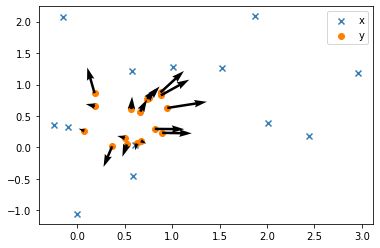

In [10]:
plt.scatter(x[:, 0], x[:, 1], label="x", marker="x")
plt.scatter(y[:, 0], y[:, 1], label="y")
plt.quiver(y[:, 0], y[:, 1], -gradient[:, 0], -gradient[:, 1])
plt.legend()

For instance, this gradient can be used to update the dataset `y` to make it go towards `x`:

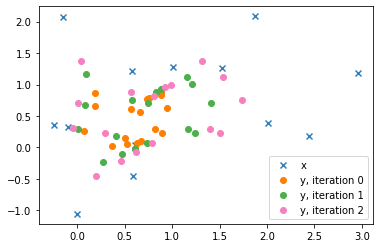

In [11]:
step_size = 2.0

plt.scatter(x[:, 0], x[:, 1], label="x", marker="x")
for i in range(3):
    plt.scatter(y[:, 0], y[:, 1], label=f"y, iteration {i}")
    y -= step_size * gradient_function(y)
plt.legend()